# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

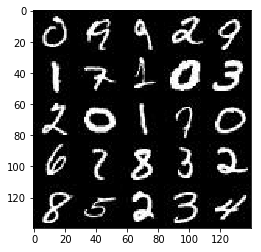

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

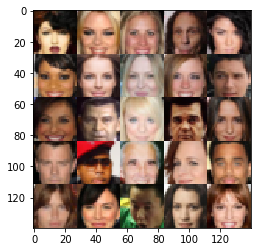

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0-rc2
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [10]:
def discriminator(images, reuse=False, keep_prob=None, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    kernel_size = 5
    stride_size = 2
    with tf.variable_scope('discriminator', reuse=reuse):
        conv1 = tf.layers.conv2d(images, 64, kernel_size, stride_size, 'same',
                                kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum(alpha * conv1, conv1)
        if keep_prob != None:
            x1 = tf.nn.dropout(x1, keep_prob)
        
        conv2 = tf.layers.conv2d(x1, 128, kernel_size, stride_size, 'same',
                                kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(conv2, training=True)
        x2 = tf.maximum(alpha * bn2, bn2)
        if keep_prob != None:
            x2 = tf.nn.dropout(x2, keep_prob)
        
#         conv3 = tf.layers.conv2d(x2, 256, kernel_size, stride_size, 'same',
#                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
#         bn3 = tf.layers.batch_normalization(conv3, training=True)
#         x3 = tf.maximum(alpha * bn3, bn3)
#         if keep_prob != None:
#         x3 = tf.nn.dropout(x3, keep_prob)
        
        x4 = tf.reshape(x2, (-1, 4*4*128))
        logits = tf.layers.dense(x4, 1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [23]:
def generator(z, out_channel_dim, is_train=True, keep_prob=None, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    start_dim_size = 2
    kernel_size = 5
    stride_size = 2
    depth_mult = 1
    with tf.variable_scope('generator', reuse=not is_train):
        d1 = tf.layers.dense(z, start_dim_size * start_dim_size * 512*depth_mult)
        d1 = tf.reshape(d1, (-1, start_dim_size, start_dim_size, 512*depth_mult))
        bn1 = tf.layers.batch_normalization(d1, training=is_train)
        x1 = tf.maximum(alpha * bn1, bn1)
        if keep_prob != None:
            x1 = tf.nn.dropout(x1, keep_prob)
    
        conv2 = tf.layers.conv2d_transpose(x1, 256*depth_mult, kernel_size, stride_size, 'valid',
                                kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(conv2, training=is_train)
        x2 = tf.maximum(alpha * bn2, bn2)
        if keep_prob != None:
            x2 = tf.nn.dropout(x2, keep_prob)
    
        conv3 = tf.layers.conv2d_transpose(x2, 128*depth_mult, kernel_size, stride_size, 'same',
                                kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(conv3, training=is_train)
        x3 = tf.maximum(alpha * bn3, bn3)
        if keep_prob != None:
            x3 = tf.nn.dropout(x3, keep_prob)
    
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, kernel_size, stride_size, 'same')
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [14]:
def model_loss(input_real, input_z, out_channel_dim, keep_prob=None):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, keep_prob=keep_prob)
    d_model_real, d_logits_real = discriminator(input_real, keep_prob=keep_prob)
    d_model_fake, d_logits_fake = discriminator(g_model, keep_prob=keep_prob, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [15]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [17]:
def train(epoch_count, batch_size, z_dim, learn_rate, beta1, get_batches, data_shape, data_image_mode, alpha=0.2):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, learning_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    n_images = 25
    steps = 0
    print_every = 50
    show_every = 200
    losses = []
    keep_prob_value = 0.5
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                steps += 1
                
                _ = sess.run(d_train_opt, feed_dict={
                    input_real: batch_images, input_z: batch_z, learning_rate: learn_rate,
                    keep_prob: keep_prob_value
                })
                _ = sess.run(g_train_opt, feed_dict={
                    input_z: batch_z, learning_rate: learn_rate,
                    keep_prob: keep_prob_value
                })
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, data_shape[3], data_image_mode)
    return losses
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.4814... Generator Loss: 0.9878
Epoch 1/2... Discriminator Loss: 1.2325... Generator Loss: 0.6668
Epoch 1/2... Discriminator Loss: 1.3599... Generator Loss: 2.0578
Epoch 1/2... Discriminator Loss: 1.2456... Generator Loss: 1.4514


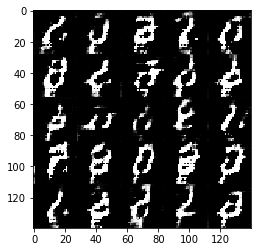

Epoch 1/2... Discriminator Loss: 1.2089... Generator Loss: 0.8597
Epoch 1/2... Discriminator Loss: 1.2594... Generator Loss: 0.6415
Epoch 1/2... Discriminator Loss: 1.3945... Generator Loss: 0.6809
Epoch 1/2... Discriminator Loss: 1.3698... Generator Loss: 0.7387


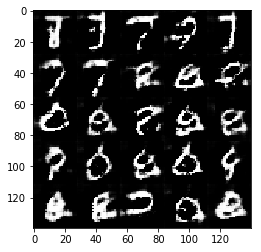

Epoch 1/2... Discriminator Loss: 1.3029... Generator Loss: 0.9492
Epoch 1/2... Discriminator Loss: 1.3941... Generator Loss: 0.5549
Epoch 1/2... Discriminator Loss: 1.6450... Generator Loss: 1.0094
Epoch 1/2... Discriminator Loss: 1.2826... Generator Loss: 0.7146


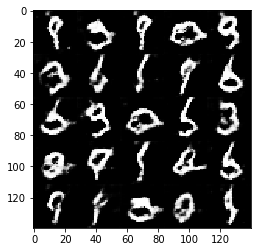

Epoch 1/2... Discriminator Loss: 1.2663... Generator Loss: 0.8653
Epoch 1/2... Discriminator Loss: 1.3017... Generator Loss: 0.8331
Epoch 1/2... Discriminator Loss: 1.2925... Generator Loss: 0.6172
Epoch 1/2... Discriminator Loss: 1.3654... Generator Loss: 0.9125


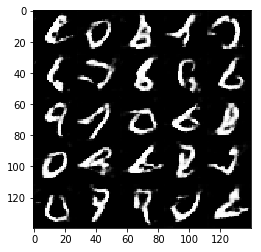

Epoch 1/2... Discriminator Loss: 1.2944... Generator Loss: 0.9879
Epoch 1/2... Discriminator Loss: 1.4149... Generator Loss: 0.8394
Epoch 2/2... Discriminator Loss: 1.3705... Generator Loss: 0.9581
Epoch 2/2... Discriminator Loss: 1.2851... Generator Loss: 0.7587


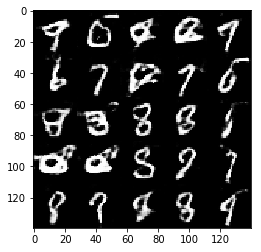

Epoch 2/2... Discriminator Loss: 1.2796... Generator Loss: 0.8089
Epoch 2/2... Discriminator Loss: 1.2929... Generator Loss: 0.6550
Epoch 2/2... Discriminator Loss: 1.2522... Generator Loss: 0.6920
Epoch 2/2... Discriminator Loss: 1.4487... Generator Loss: 1.1334


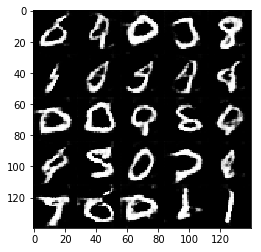

Epoch 2/2... Discriminator Loss: 1.2756... Generator Loss: 0.6700
Epoch 2/2... Discriminator Loss: 1.2522... Generator Loss: 0.9859
Epoch 2/2... Discriminator Loss: 1.2739... Generator Loss: 0.7740
Epoch 2/2... Discriminator Loss: 1.1935... Generator Loss: 0.7850


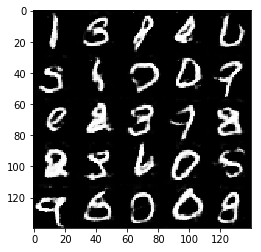

Epoch 2/2... Discriminator Loss: 1.2659... Generator Loss: 0.7111
Epoch 2/2... Discriminator Loss: 1.2442... Generator Loss: 0.9456
Epoch 2/2... Discriminator Loss: 1.3154... Generator Loss: 0.8269
Epoch 2/2... Discriminator Loss: 1.3079... Generator Loss: 0.6229


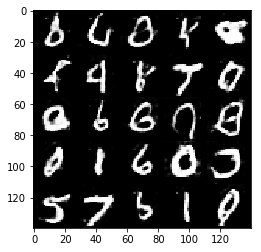

Epoch 2/2... Discriminator Loss: 1.2307... Generator Loss: 0.7491
Epoch 2/2... Discriminator Loss: 1.3317... Generator Loss: 0.9581
Epoch 2/2... Discriminator Loss: 1.2372... Generator Loss: 0.9354
Epoch 2/2... Discriminator Loss: 1.1914... Generator Loss: 0.8031


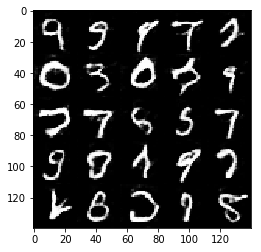

Epoch 2/2... Discriminator Loss: 1.2791... Generator Loss: 0.7676


In [18]:
batch_size = 64
z_dim = 100
learning_rate = 0.008
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    losses = train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

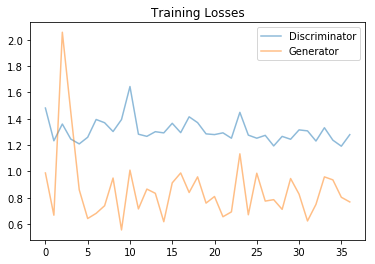

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2... Discriminator Loss: 1.4487... Generator Loss: 0.8554
Epoch 1/2... Discriminator Loss: 1.2951... Generator Loss: 0.8510
Epoch 1/2... Discriminator Loss: 0.5878... Generator Loss: 1.4081
Epoch 1/2... Discriminator Loss: 0.5833... Generator Loss: 1.8834


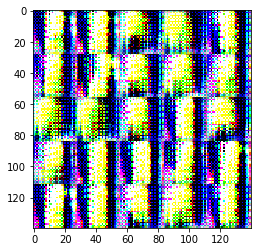

Epoch 1/2... Discriminator Loss: 0.2751... Generator Loss: 2.2365
Epoch 1/2... Discriminator Loss: 1.0810... Generator Loss: 0.8242
Epoch 1/2... Discriminator Loss: 0.9176... Generator Loss: 2.4107
Epoch 1/2... Discriminator Loss: 1.1617... Generator Loss: 0.8758


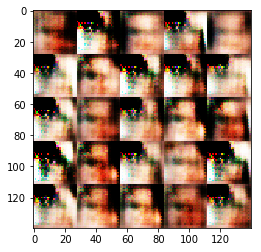

Epoch 1/2... Discriminator Loss: 1.0869... Generator Loss: 1.1221
Epoch 1/2... Discriminator Loss: 1.3015... Generator Loss: 0.7779
Epoch 1/2... Discriminator Loss: 1.3513... Generator Loss: 0.6030
Epoch 1/2... Discriminator Loss: 1.2505... Generator Loss: 0.9619


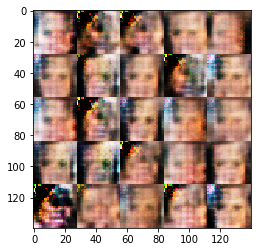

Epoch 1/2... Discriminator Loss: 1.2444... Generator Loss: 0.6973
Epoch 1/2... Discriminator Loss: 1.3325... Generator Loss: 1.1851
Epoch 1/2... Discriminator Loss: 1.3452... Generator Loss: 0.8204
Epoch 1/2... Discriminator Loss: 1.3394... Generator Loss: 0.7539


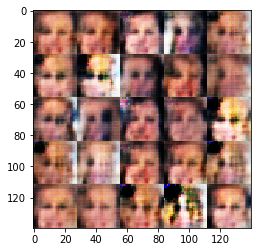

Epoch 1/2... Discriminator Loss: 1.2085... Generator Loss: 0.8445
Epoch 1/2... Discriminator Loss: 1.2551... Generator Loss: 0.8542
Epoch 1/2... Discriminator Loss: 1.3330... Generator Loss: 0.8223
Epoch 1/2... Discriminator Loss: 1.2366... Generator Loss: 0.7030


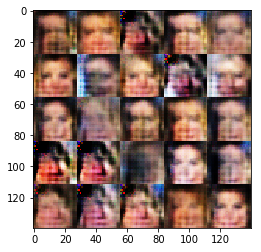

Epoch 1/2... Discriminator Loss: 1.3275... Generator Loss: 0.6342
Epoch 1/2... Discriminator Loss: 1.2329... Generator Loss: 0.7730
Epoch 1/2... Discriminator Loss: 1.3447... Generator Loss: 0.6981
Epoch 1/2... Discriminator Loss: 1.2992... Generator Loss: 0.6948


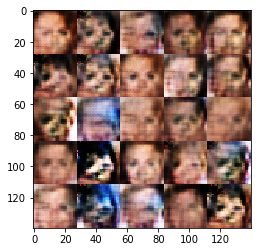

Epoch 1/2... Discriminator Loss: 1.2974... Generator Loss: 0.7658
Epoch 1/2... Discriminator Loss: 1.2434... Generator Loss: 0.7034
Epoch 1/2... Discriminator Loss: 1.1128... Generator Loss: 1.5185
Epoch 1/2... Discriminator Loss: 1.1677... Generator Loss: 1.0777


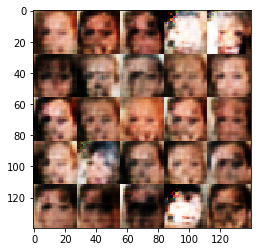

Epoch 1/2... Discriminator Loss: 0.0257... Generator Loss: 4.4092
Epoch 1/2... Discriminator Loss: 1.2817... Generator Loss: 1.4835
Epoch 1/2... Discriminator Loss: 0.1923... Generator Loss: 4.6704
Epoch 1/2... Discriminator Loss: 0.0585... Generator Loss: 5.2139


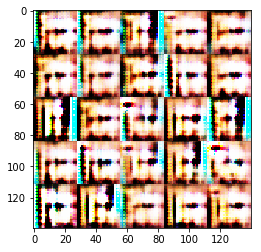

Epoch 1/2... Discriminator Loss: 0.0303... Generator Loss: 4.3286
Epoch 1/2... Discriminator Loss: 0.0234... Generator Loss: 8.2959
Epoch 1/2... Discriminator Loss: 0.0046... Generator Loss: 7.9085
Epoch 1/2... Discriminator Loss: 0.0447... Generator Loss: 3.9061


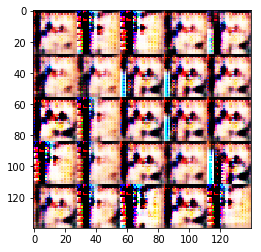

Epoch 1/2... Discriminator Loss: 0.8096... Generator Loss: 1.1442
Epoch 1/2... Discriminator Loss: 1.4496... Generator Loss: 3.2592
Epoch 1/2... Discriminator Loss: 1.5265... Generator Loss: 0.8556
Epoch 1/2... Discriminator Loss: 0.9672... Generator Loss: 1.3588


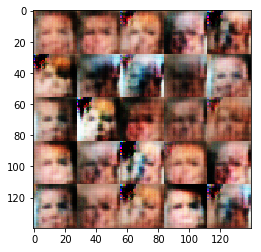

Epoch 1/2... Discriminator Loss: 1.3177... Generator Loss: 0.9217
Epoch 1/2... Discriminator Loss: 1.1777... Generator Loss: 0.9196
Epoch 1/2... Discriminator Loss: 1.4482... Generator Loss: 0.7536
Epoch 1/2... Discriminator Loss: 1.3740... Generator Loss: 0.9433


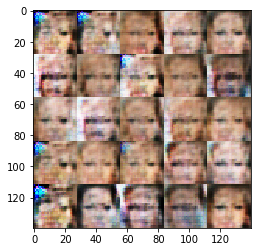

Epoch 1/2... Discriminator Loss: 1.1861... Generator Loss: 0.8615
Epoch 1/2... Discriminator Loss: 1.3620... Generator Loss: 1.3483
Epoch 1/2... Discriminator Loss: 1.2306... Generator Loss: 0.8635
Epoch 1/2... Discriminator Loss: 1.2754... Generator Loss: 0.8368


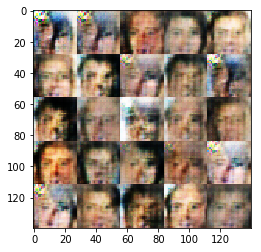

Epoch 1/2... Discriminator Loss: 1.3362... Generator Loss: 0.6033
Epoch 1/2... Discriminator Loss: 1.2721... Generator Loss: 0.7580
Epoch 1/2... Discriminator Loss: 1.2212... Generator Loss: 0.8573
Epoch 1/2... Discriminator Loss: 1.3426... Generator Loss: 0.6125


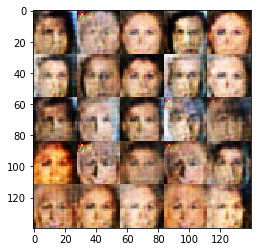

Epoch 1/2... Discriminator Loss: 1.3581... Generator Loss: 0.6424
Epoch 1/2... Discriminator Loss: 1.3358... Generator Loss: 0.7628
Epoch 1/2... Discriminator Loss: 1.3952... Generator Loss: 0.5894
Epoch 1/2... Discriminator Loss: 1.2660... Generator Loss: 0.7862


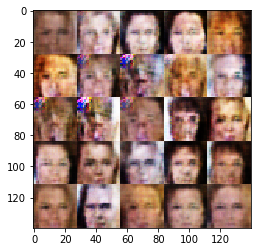

Epoch 1/2... Discriminator Loss: 1.3065... Generator Loss: 0.7309
Epoch 1/2... Discriminator Loss: 1.2368... Generator Loss: 0.7861
Epoch 1/2... Discriminator Loss: 1.3302... Generator Loss: 0.6361
Epoch 1/2... Discriminator Loss: 1.2981... Generator Loss: 0.7781


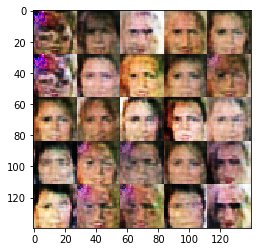

Epoch 1/2... Discriminator Loss: 1.3220... Generator Loss: 0.6918
Epoch 1/2... Discriminator Loss: 1.3660... Generator Loss: 0.5619
Epoch 1/2... Discriminator Loss: 1.2907... Generator Loss: 0.6927
Epoch 2/2... Discriminator Loss: 1.2888... Generator Loss: 0.7897


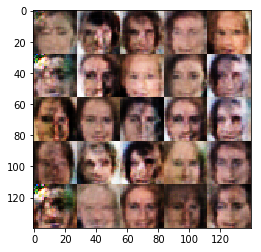

Epoch 2/2... Discriminator Loss: 1.4610... Generator Loss: 0.5388
Epoch 2/2... Discriminator Loss: 1.3206... Generator Loss: 0.8658
Epoch 2/2... Discriminator Loss: 1.2545... Generator Loss: 0.7262
Epoch 2/2... Discriminator Loss: 1.3503... Generator Loss: 0.6682


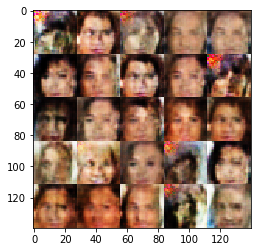

Epoch 2/2... Discriminator Loss: 1.3371... Generator Loss: 0.6366
Epoch 2/2... Discriminator Loss: 1.3729... Generator Loss: 0.6938
Epoch 2/2... Discriminator Loss: 1.6024... Generator Loss: 0.3612


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.008
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    losses = train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, alpha=0.1)

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.